# Analysis of scRNA-seq from trophoblast organoid experiments 
### (experiments #1 and #2)

# Performing DE analysis in a ct-vs-previous manner for DoRothEA

10.2021

02.2022: with updated (final_annot_v9) annotation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'

# 1. Reading in the non-activated organoid data object with annotation (from notebook `S7`)

In [6]:
# annotation in final_annot_v9
# normalised and log tr values in .X, all filtered genes and same in .raw
adata_organoids = sc.read(save_path + 'adata_scVI_analysed_no_cytokines_after_scVI_with_gene_filter_and_excluding_filter_mix_cluster.h5ad')


In [7]:
adata_organoids

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'prelim_annot_v2', 'S_score', 'G2M_score', 'phase', 'celltype_predictions_P13', 'probabilities_P13', 'celltype_predictions_Roser', 'probabilities_Roser', 'louvain', 'louvain_R', 'barcode_sample_copy', 'prelim_annot_v3', 'final_annot_v4', 'louvain_R_5', 'louvain_R_5,1', 'louvain_R_4', 'louvain_RR_4', 'louvain_final', 'louvain_RR_4_1', 'final_annot_v5', 'final_annot_v6', 'final_annot_v7', 'final_annot_v8', 'final_annot_v9'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_ce

In [8]:
np.unique(adata_organoids.obs['sample'])

array(['6044STDY8640561', '6044STDY8640563', '6044STDY8640565',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123932', 'Pla_Camb10123934'], dtype=object)

In [9]:
np.unique(adata_organoids[adata_organoids.obs['sample'] == 'Pla_Camb10123928'].X.todense())

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


matrix([[0.      , 0.      , 0.      , ..., 8.140675, 8.180016, 8.313156]],
       dtype=float32)

In [10]:
# this manifold worked best - 40 latent variables, corrected by donor_sample key
curr_embedding_key = 'X_umap_scVI_n_latent_40_donor_sample_gf_v3'

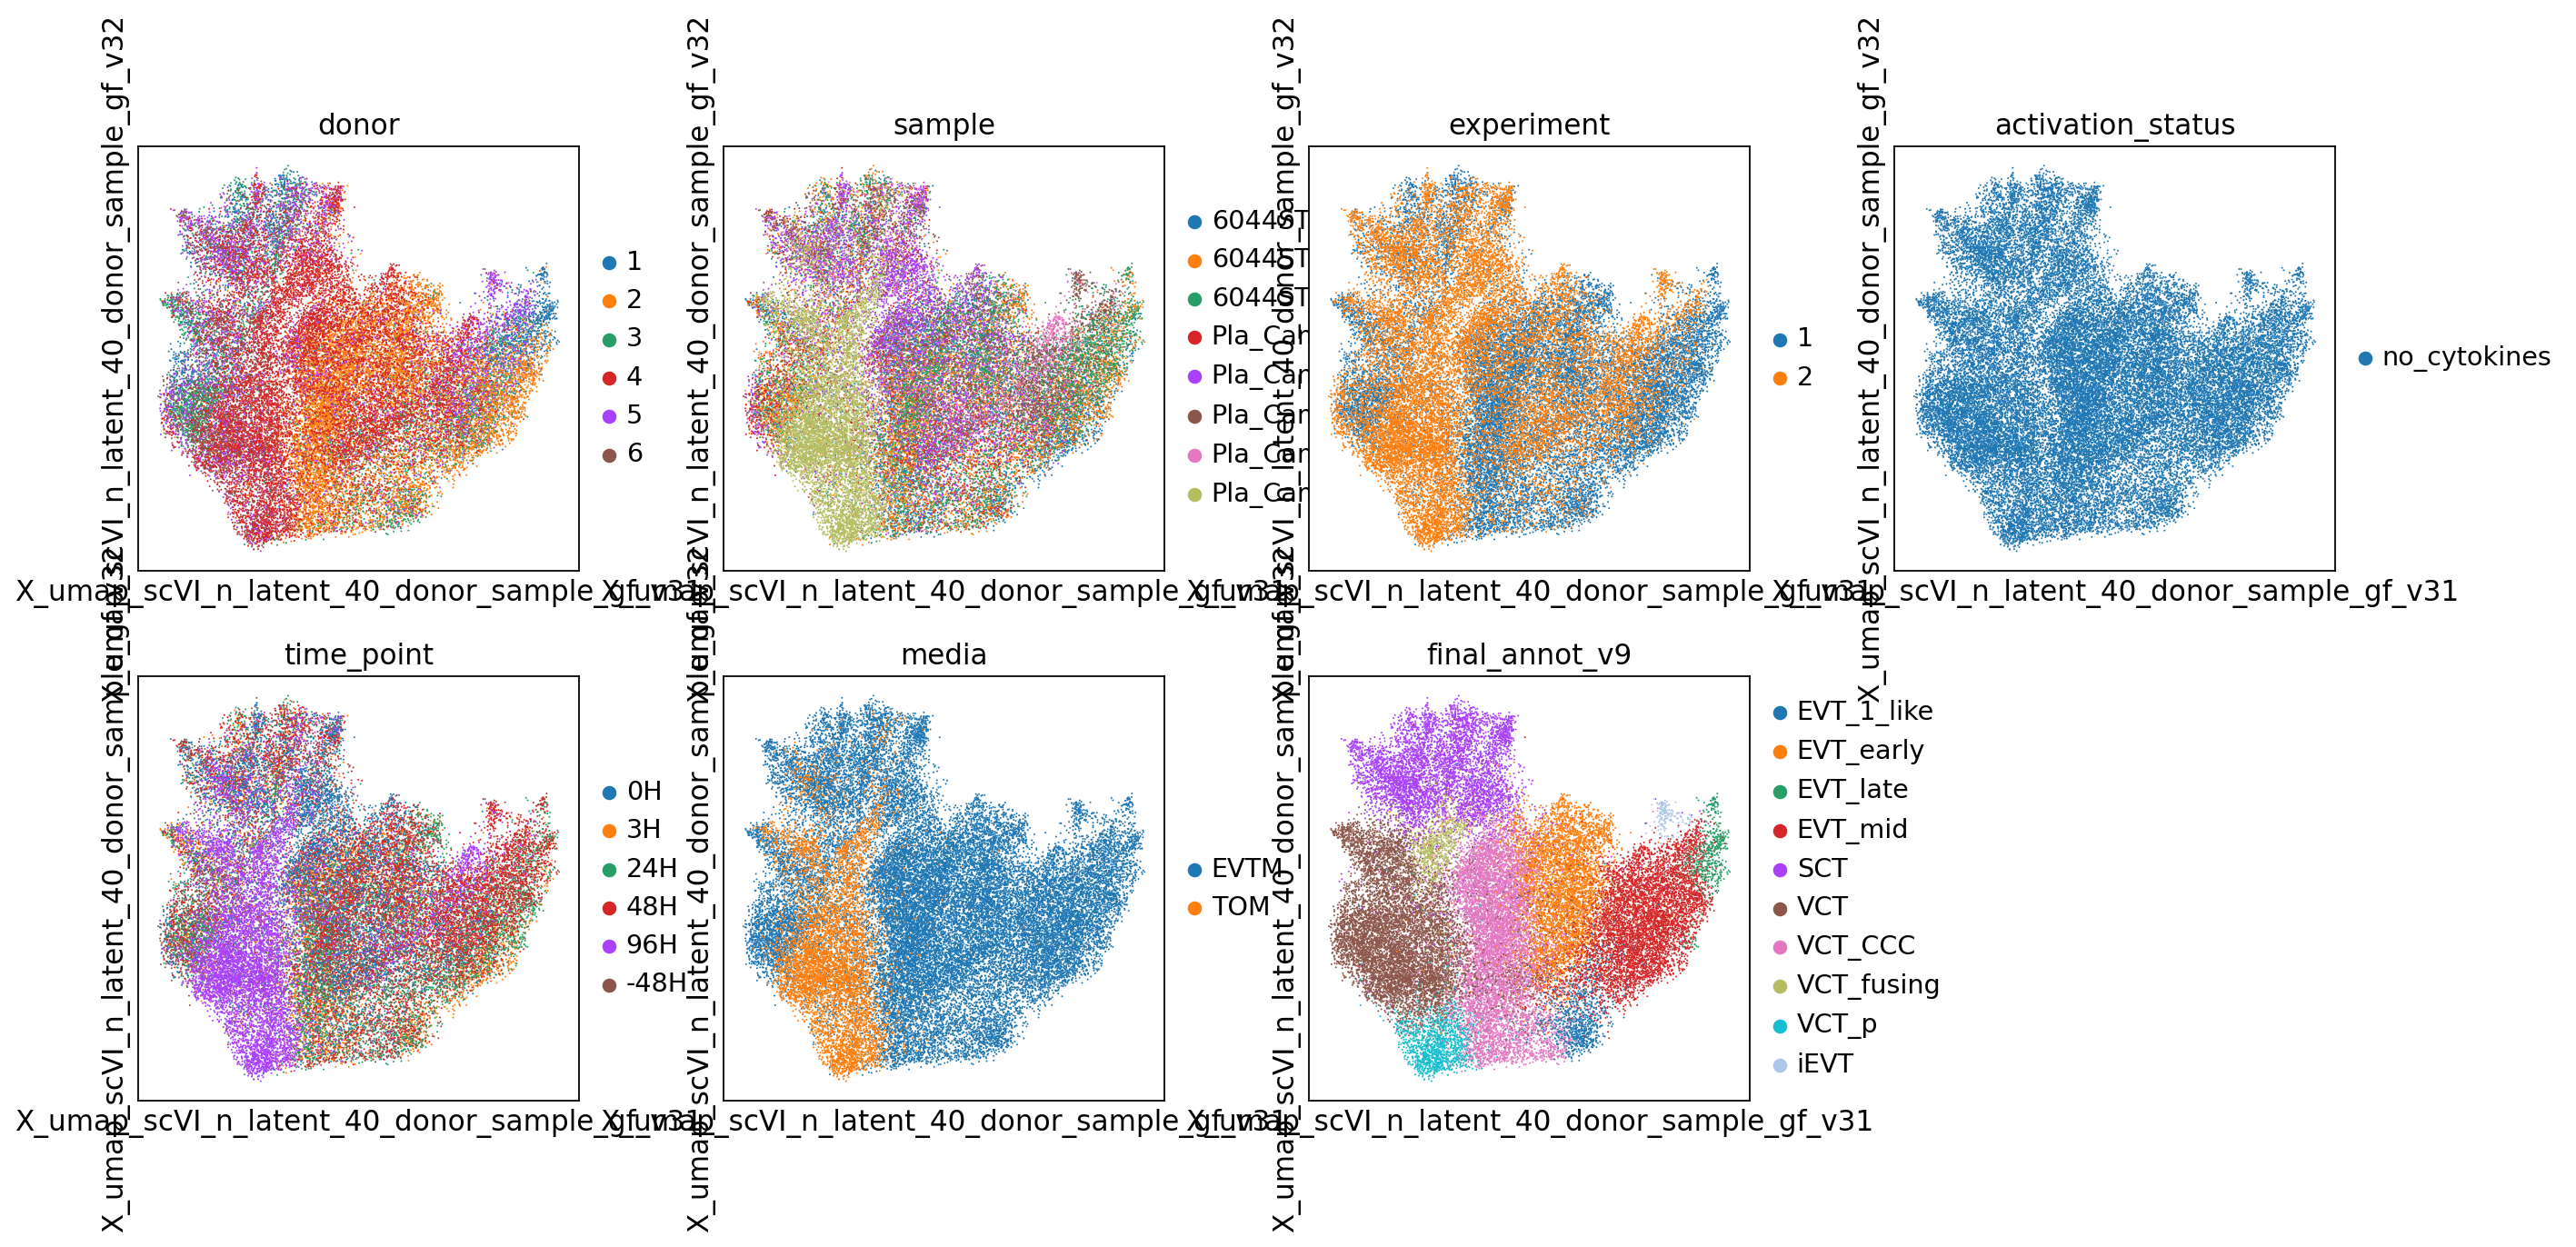

In [11]:
sc.pl.embedding(adata_organoids, curr_embedding_key,
                color=['donor','sample', 'experiment', 'activation_status', 'time_point', 'media','final_annot_v9'],
          )

# DE with limma

- VCT_CCC vs [VCT + VCT_p]
- EVT_1_like vs VCT_CCC
- EVT_early vs VCT_CCC
- EVT_mid vs [EVT_early and EVT_1_like]
- iEVT vs [EVT_mid and EVT_late]
- EVT_late vs EVT_mid

skipping these 2 for now since focusing on the invading EVT populations
- SCT vs VCT_fusing
- VCT_fusing vs VCT

In [8]:
np.unique(adata_organoids.obs['donor'])

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [9]:
np.unique(adata_organoids.obs['final_annot_v9'])

array(['EVT_1_like', 'EVT_early', 'EVT_late', 'EVT_mid', 'SCT', 'VCT',
       'VCT_CCC', 'VCT_fusing', 'VCT_p', 'iEVT'], dtype=object)

In [10]:
# this object contains normalised and log transformed values both in .X and in .raw.X
adata_organoids

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'prelim_annot_v2', 'S_score', 'G2M_score', 'phase', 'celltype_predictions_P13', 'probabilities_P13', 'celltype_predictions_Roser', 'probabilities_Roser', 'louvain', 'louvain_R', 'barcode_sample_copy', 'prelim_annot_v3', 'final_annot_v4', 'louvain_R_5', 'louvain_R_5,1', 'louvain_R_4', 'louvain_RR_4', 'louvain_final', 'louvain_RR_4_1', 'final_annot_v5', 'final_annot_v6', 'final_annot_v7', 'final_annot_v8', 'final_annot_v9'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_ce

In [11]:
# creating also the full object (all genes) - normalised and log transformed
adata_full = anndata.AnnData(X=adata_organoids.raw.X,
                            obs=adata_organoids.obs,
                            var=adata_organoids.raw.var,
                            obsm=adata_organoids.obsm)


In [12]:
adata_full

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'prelim_annot_v2', 'S_score', 'G2M_score', 'phase', 'celltype_predictions_P13', 'probabilities_P13', 'celltype_predictions_Roser', 'probabilities_Roser', 'louvain', 'louvain_R', 'barcode_sample_copy', 'prelim_annot_v3', 'final_annot_v4', 'louvain_R_5', 'louvain_R_5,1', 'louvain_R_4', 'louvain_RR_4', 'louvain_final', 'louvain_RR_4_1', 'final_annot_v5', 'final_annot_v6', 'final_annot_v7', 'final_annot_v8', 'final_annot_v9'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_ce

In [13]:
np.unique(adata_full.obs['activation_status'])

array(['no_cytokines'], dtype=object)

In [14]:
adata_full

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'prelim_annot_v2', 'S_score', 'G2M_score', 'phase', 'celltype_predictions_P13', 'probabilities_P13', 'celltype_predictions_Roser', 'probabilities_Roser', 'louvain', 'louvain_R', 'barcode_sample_copy', 'prelim_annot_v3', 'final_annot_v4', 'louvain_R_5', 'louvain_R_5,1', 'louvain_R_4', 'louvain_RR_4', 'louvain_final', 'louvain_RR_4_1', 'final_annot_v5', 'final_annot_v6', 'final_annot_v7', 'final_annot_v8', 'final_annot_v9'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_ce

In [15]:
np.unique(adata_full.obs['final_annot_v9'], return_counts=True)

(array(['EVT_1_like', 'EVT_early', 'EVT_late', 'EVT_mid', 'SCT', 'VCT',
        'VCT_CCC', 'VCT_fusing', 'VCT_p', 'iEVT'], dtype=object),
 array([ 940, 4966,  562, 6198, 5336, 8578, 8498,  813, 1431,  158]))

In [16]:
adata_full.obs['final_annot_v9'].value_counts()

VCT           8578
VCT_CCC       8498
EVT_mid       6198
SCT           5336
EVT_early     4966
VCT_p         1431
EVT_1_like     940
VCT_fusing     813
EVT_late       562
iEVT           158
Name: final_annot_v9, dtype: int64

In [30]:
# marker calling

# pre-GC vs iEVT
curr_adata = adata_full[adata_full.obs['final_annot_v9'].isin(['EVT_mid','EVT_late'])].copy()
curr_adata.obs['curr_comparison_limma'] = adata_full.obs['final_annot_v9']
#curr_adata.obs['curr_comparison_limma'] = ['VCT' if annot in ['VCT','VCT_p'] else annot for annot in curr_adata.obs['curr_comparison_limma']]
#curr_adata.obs['curr_comparison_limma'] = ['EVT_early_all' if annot in ['EVT_1_like','EVT_early'] else annot for annot in curr_adata.obs['curr_comparison_limma']]
#curr_adata.obs['curr_comparison_limma'] = ['EVT_mid_and_late' if annot in ['EVT_mid','EVT_late'] else annot for annot in curr_adata.obs['curr_comparison_limma']]

curr_comparison = 'curr_comparison_limma'

t = curr_adata.X.toarray().T
df = pd.DataFrame(data=t, columns= curr_adata.obs.index, index=curr_adata.var_names)

meta_df = pd.DataFrame(data={'Cell':list(curr_adata.obs.index),
                             #'cell_type':[ str(i) for i in curr_adata.obs['celltype_condition']],
                             'cell_type':[ str(i) for i in curr_adata.obs[curr_comparison]],
                             # using donor and sample as covariates?
                             'sample':[ str(i) for i in curr_adata.obs['sample']],
                             'donor':[ str(i) for i in curr_adata.obs['donor']]
                            })
meta_df.set_index('Cell', inplace=True)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [31]:
#meta_df

In [32]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['EVT_late', 'EVT_mid'], dtype=object), array([ 562, 6198]))

In [33]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [34]:
outpath = './limma_DEGs/20220218_with_donor_covariate/'

In [35]:
%%R
library(limma)
library(edgeR)

In [36]:
%%R

# checking limma and edgeR versions in R

sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] edgeR_3.32.1 limma_3.46.0

loaded via a namespace (and not attached):
[1] compiler_4.0.4  Rcpp_1.0.8      grid_4.0.4      locfit_1.5-9.4 
[5] lattice_0.20-41


In [37]:
meta_df.reset_index(inplace=True)

In [38]:
#meta_df

In [39]:
df

barcode_sample,AAACGAAGTGCATTAC-1_6044STDY8640561,AAACGCTGTTGACTAC-1_6044STDY8640561,AAAGAACAGTCATGAA-1_6044STDY8640561,AAAGGGCAGCGAAACC-1_6044STDY8640561,AAAGGGCCATATCTGG-1_6044STDY8640561,AAAGGTACATTGCTGA-1_6044STDY8640561,AAAGTCCAGTGTTCAC-1_6044STDY8640561,AAAGTCCGTTGACTGT-1_6044STDY8640561,AAATGGAAGACGCAGT-1_6044STDY8640561,AAATGGATCGGAGCAA-1_6044STDY8640561,...,TTGTGTTAGTCTCCTC-1_Pla_Camb10123932,TTGTTCAGTCCTGTTC-1_Pla_Camb10123932,TTTCAGTTCGAGGCAA-1_Pla_Camb10123932,TTTCATGCATACAGCT-1_Pla_Camb10123932,TTTCATGCATGCCGAC-1_Pla_Camb10123932,TTTCGATAGGCTAGCA-1_Pla_Camb10123932,TTTCGATTCGTGCAGC-1_Pla_Camb10123932,TTTGACTAGTATGAAC-1_Pla_Camb10123932,TTTGACTGTTGGACCC-1_Pla_Camb10123932,TTTGACTTCGAACGGA-1_Pla_Camb10123932
A1BG,0.000000,0.000000,0.0,0.435267,0.0,0.000000,0.0,0.0,0.000000,0.732775,...,0.000000,0.000000,0.000000,0.413207,0.000000,0.256572,0.000000,0.778214,0.518323,0.000000
A1BG-AS1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.256572,0.000000,0.000000,0.000000,0.000000
A2M,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M-AS1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.157476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.000000,0.500817,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZYG11A,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.157476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZYG11B,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.694676,0.000000,0.520108,0.000000,0.000000,0.388301,0.000000,0.000000,0.000000
ZYX,0.557593,1.081874,0.0,0.435267,0.0,0.798596,0.0,0.0,0.719987,0.000000,...,0.316924,0.406484,1.059037,0.785666,0.000000,0.000000,0.388301,0.000000,1.111077,0.357027


In [40]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['EVT_late', 'EVT_mid'], dtype=object), array([ 562, 6198]))

In [41]:
case = 'EVT_late'
ctrl = 'EVT_mid'

In [42]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariate_sample = meta_df$sample
covariate_donor = meta_df$donor

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

design.matrix <- model.matrix(~ 0 + cluster_type + covariate_donor) #+ covariate_sample)
#design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20220218_', case, 
                                 #'_vs_', ctrl, # omitting this from the names bc comparisons are kind of complicated in terms of order of cell states
                                 '_no_cytokines_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)


[1] "EVT_mid"  "EVT_late"


R[write to console]: 6760 shared cells



[1] "ctrl" "case"


In [75]:
# genes upreg in pre-GC vs iEVT comparison
DEGs = {}

comparisons = ['iEVT_vs_EVT','EVT_vs_EVT_early','EVT_early_vs_VCT_CCC',
               'VCT_CCC_vs_VCT']

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('./limma_DEGs/20220116_with_donor_covariate/20220116_' + comparison + '_no_cytokines_limma_DEGs.csv', 
                                   index_col=0)
    DEGs[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs[comparison] = DEGs[comparison][DEGs[comparison]['logFC'] > 0]
    print('number of DEGs overall:', len(DEGs[comparison]),'\n')

iEVT_vs_EVT
number of DEGs overall: 5159 

EVT_vs_EVT_early
number of DEGs overall: 3913 

EVT_early_vs_VCT_CCC
number of DEGs overall: 3902 

VCT_CCC_vs_VCT
number of DEGs overall: 6016 



In [59]:
# OLD

# genes upreg in pre-GC vs iEVT comparison
DEGs = {}

comparisons = ['pre-GC_vs_iEVT','pre-eEVT_vs_iEVT','iEVT_vs_EVT_early','EVT_early_vs_VCT_CCC',
               'VCT_CCC_vs_VCT', 'SCT_vs_VCT_fusing', 'VCT_fusing_vs_VCT']

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('./limma_DEGs/20211012_with_donor_cov/20211012_' + comparison + '_no_cytokines_limma_DEGs.csv', 
                                   index_col=0)
    DEGs[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs[comparison] = DEGs[comparison][DEGs[comparison]['logFC'] > 0]
    print('number of DEGs overall:', len(DEGs[comparison]),'\n')

pre-GC_vs_iEVT
number of DEGs overall: 5117 

pre-eEVT_vs_iEVT
number of DEGs overall: 2539 

iEVT_vs_EVT_early
number of DEGs overall: 3809 

EVT_early_vs_VCT_CCC
number of DEGs overall: 3902 

VCT_CCC_vs_VCT
number of DEGs overall: 6016 

SCT_vs_VCT_fusing
number of DEGs overall: 2056 

VCT_fusing_vs_VCT
number of DEGs overall: 3374 



In [61]:
pd.options.display.max_rows = 500

In [62]:
DEGs['VCT_CCC_vs_VCT'][:500]

,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest
Gene,,,,,,,
TPM1,1.694431,0.000000e+00,0.000000e+00,3.181345,1.266565,0.982113,0.734939
EBI3,1.412315,0.000000e+00,0.000000e+00,1.788107,0.500766,0.891269,0.331801
IGFBP3,1.552382,0.000000e+00,0.000000e+00,1.816358,0.233714,0.805484,0.163653
PLAC8,1.018368,0.000000e+00,0.000000e+00,1.278056,0.285141,0.832196,0.254171
FN1,1.280309,0.000000e+00,0.000000e+00,1.209701,0.198201,0.597435,0.171646
PRSS8,1.005152,0.000000e+00,0.000000e+00,1.641081,0.554843,0.912332,0.468578
ECE1,0.702300,0.000000e+00,0.000000e+00,0.846392,0.209023,0.703695,0.285543
EFNA1,0.941334,0.000000e+00,0.000000e+00,1.689257,0.526665,0.894210,0.485963
FLT1,1.225931,0.000000e+00,0.000000e+00,1.956121,0.849637,0.880442,0.631132


In [36]:
# no covariates
# EVT vs rest
DEGs = pd.read_csv('./limma_DEGs/20211008_EVT_vs_rest_no_cytokines_limma_DEGs.csv',
                          index_col = 0)
DEGs = DEGs[DEGs['adj.P.Val'] < 0.05]
DEGs = DEGs[DEGs['logFC'] > 0]
print('number of DEGs overall:', len(DEGs))

number of DEGs overall: 5377


In [37]:
DEGs

,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest
Gene,,,,,,,
FSTL3,2.272188,0.000000,0.000000,3.245848,0.973660,0.965845,0.556822
LGALS1,1.894985,0.000000,0.000000,2.210094,0.315108,0.811993,0.281919
COL4A1,1.520676,0.000000,0.000000,1.966994,0.446319,0.859950,0.419573
SLCO4A1,0.961798,0.000000,0.000000,1.157350,0.195552,0.798269,0.196747
NOTUM,1.968249,0.000000,0.000000,2.258447,0.290198,0.743450,0.252109
...,...,...,...,...,...,...,...
AC021072.1,0.000105,0.030923,0.049863,0.000105,0.000000,0.000234,0.000000
HOGA1,0.000121,0.030924,0.049863,0.000128,0.000008,0.000234,0.000041
AL365394.1,0.000308,0.030952,0.049904,0.000454,0.000146,0.000780,0.000243


# using no covariates here is better bc technically we already corrected with scVI and this way I also get less DEGs (but still enough)

In [38]:
# EVT vs VCT_CCC
DEGs_EVT_vs_CCC = pd.read_csv('./limma_DEGs/20211008_EVT_vs_VCT_CCC_no_cytokines_limma_DEGs.csv',
                          index_col = 0)
DEGs_EVT_vs_CCC = DEGs_EVT_vs_CCC[DEGs_EVT_vs_CCC['adj.P.Val'] < 0.05]
DEGs_EVT_vs_CCC = DEGs_EVT_vs_CCC[DEGs_EVT_vs_CCC['logFC'] > 0]
print('number of DEGs overall:', len(DEGs_EVT_vs_CCC))

number of DEGs overall: 4564


In [39]:
DEGs_EVT_vs_CCC

,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest
Gene,,,,,,,
QSOX1,1.117371,0.000000,0.000000,2.017221,0.752255,0.944635,0.630619
FSTL3,1.562882,0.000000,0.000000,3.245848,1.445125,0.965845,0.788185
LGALS1,1.629669,0.000000,0.000000,2.210094,0.383073,0.811993,0.336785
COL4A1,1.262716,0.000000,0.000000,1.966994,0.566905,0.859950,0.503177
CDKN1C,1.031543,0.000000,0.000000,3.932624,2.838275,0.996101,0.951636
...,...,...,...,...,...,...,...
CD177,0.000370,0.024739,0.049216,0.000399,0.000000,0.000858,0.000000
ACER2,0.004521,0.024791,0.049307,0.028334,0.023136,0.055599,0.035067
FAM220A,0.005876,0.024876,0.049466,0.046948,0.045913,0.085777,0.073194


In [40]:
len(set(DEGs_EVT_vs_CCC.index) & set(DEGs.index))

3434

In [41]:
# sample and donor covariates
# EVT vs rest
DEGs_cov = pd.read_csv('./limma_DEGs/20211008_EVT_vs_rest_no_cytokines_with_sample_donor_covariates_limma_DEGs.csv',
                          index_col = 0)
DEGs_cov = DEGs_cov[DEGs_cov['adj.P.Val'] < 0.05]
DEGs_cov = DEGs_cov[DEGs_cov['logFC'] > 0]
print('number of DEGs overall:', len(DEGs_cov))

number of DEGs overall: 6051


In [42]:
DEGs_cov

,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest
Gene,,,,,,,
LGALS1,1.748443,0.000000,0.000000,2.210094,0.315108,0.811993,0.281919
FSTL3,1.811961,0.000000,0.000000,3.245848,0.973660,0.965845,0.556822
COL4A1,1.376997,0.000000,0.000000,1.966994,0.446319,0.859950,0.419573
SLCO4A1,0.896652,0.000000,0.000000,1.157350,0.195552,0.798269,0.196747
NOTUM,1.695986,0.000000,0.000000,2.258447,0.290198,0.743450,0.252109
...,...,...,...,...,...,...,...
CELF4,0.001459,0.026714,0.049693,0.005344,0.002871,0.008188,0.004624
AL109924.1,0.000180,0.026736,0.049731,0.000255,0.000049,0.000780,0.000162
ZNF461,0.002483,0.026750,0.049747,0.014364,0.014133,0.030490,0.029486


In [43]:
# intersection much?
len(set(DEGs.index) & set(DEGs_cov.index))

4802

In [44]:
len(set(DEGs.index) - set(DEGs_cov.index))

575

In [45]:
len(set(DEGs_cov.index) - set(DEGs.index))

1249

In [46]:
list(set(DEGs.index) - set(DEGs_cov.index))

['OR10A2',
 'KIF21B',
 'TSTD1',
 'AC090987.1',
 'AC107884.2',
 'CYB5R1',
 'NNMT',
 'LINC02449',
 'TRAF3IP2',
 'LINC01089',
 'CCHCR1',
 'AL161669.3',
 'B3GNT4',
 'LINC01790',
 'AC114490.3',
 'HDAC5',
 'RPP21',
 'ARL14',
 'TLE6',
 'AC118755.1',
 'LINC01098',
 'NDN',
 'PNPLA3',
 'LINC00305',
 'TUB',
 'AL022238.2',
 'LINC01993',
 'POR',
 'VEGFA',
 'PTPRD',
 'CCDC58',
 'GATA6',
 'KLF9',
 'AC012511.1',
 'AC006017.1',
 'OR2A5',
 'MTURN',
 'KCNMB2-AS1',
 'AL445472.1',
 'KIAA1324L',
 'KCND2',
 'ASPHD1',
 'CYP2R1',
 'TRPV3',
 'TRAPPC5',
 'CAMP',
 'GALNT7',
 'AC006305.1',
 'AL031674.1',
 'HS3ST6',
 'AC106886.3',
 'TMEM54',
 'FBXW5',
 'TFEC',
 'AL354732.1',
 'WNT11',
 'HDAC6',
 'AFF1',
 'HEBP2',
 'Z97192.1',
 'ZCWPW2',
 'PIK3R2',
 'IER5',
 'LINC00160',
 'KIF26B',
 'CR392000.2',
 'CA11',
 'PPP1R26',
 'SLC5A10',
 'AC009133.3',
 'CILP',
 'PDE6A',
 'RPL35',
 'AC012313.2',
 'AP005019.1',
 'AL451062.1',
 'CCDC7',
 'AC125616.1',
 'AC067930.4',
 'PITRM1-AS1',
 'LINC01473',
 'AC005899.6',
 'PRCD',
 'NMNAT3

In [47]:
list(set(DEGs_cov.index) - set(DEGs.index))

['CCDC18',
 'BCL2L12',
 'EPB41L4A',
 'HNRNPA0',
 'INO80D',
 'ALKBH3',
 'EIF3D',
 'IL10RB-DT',
 'YIPF6',
 'SCYL1',
 'DNAJC7',
 'USP9X',
 'SHQ1',
 'ADCY2',
 'PUM3',
 'TLK2',
 'PSMG1',
 'PRKAA2',
 'MMADHC',
 'RBM3',
 'AC098864.1',
 'POLR2K',
 'FBXL12',
 'CADPS2',
 'USP45',
 'BET1L',
 'ACAD11',
 'ZMYM1',
 'RAB11A',
 'CDIP1',
 'GLMP',
 'NEPRO',
 'LTBP1',
 'AC025262.1',
 'FOCAD',
 'LUC7L',
 'SWSAP1',
 'PRELID1',
 'SBNO1',
 'PRKAR2A',
 'ASCC1',
 'MROH1',
 'ARMH3',
 'DNAJC17',
 'ATE1',
 'DTX3L',
 'PUS7',
 'OBSL1',
 'CRYZL1',
 'OTUD7B',
 'CRTAP',
 'ILF2',
 'PPHLN1',
 'KLHL8',
 'DYNLL1',
 'TMED8',
 'XRCC5',
 'LAMC1',
 'DPPA4',
 'TTC13',
 'KLHL9',
 'DDX41',
 'MAPK9',
 'FAM217B',
 'PITPNC1',
 'LZTS1-AS1',
 'HIST2H2BF',
 'CREB3L2',
 'SLAIN2',
 'VPS13B',
 'LONP2',
 'CDK16',
 'HSPA14',
 'KDM6A',
 'ARHGAP17',
 'ZNF330',
 'SEMA3C',
 'ARMC8',
 'NDUFB2',
 'TMX2',
 'TRIP12',
 'PIK3C3',
 'ARHGAP12',
 'UBAP2',
 'IQGAP1',
 'SGPL1',
 'DYNC1H1',
 'CCDC61',
 'SEC24C',
 'ADSL',
 'HMBS',
 'AC008915.2',
 'LINC0221

In [39]:
pd.set_option("display.max_rows", 101)

In [98]:
# general EVT comparison

DEGs_EVT_all = pd.read_csv('./limma_DEG/20211005_EVT_prelim_all_cytokines_vs_EVT_prelim_all_no_cytokines_limma_DEGs.csv',
                          index_col = 0)
DEGs_EVT_all = DEGs_EVT_all[DEGs_EVT_all['adj.P.Val'] < 0.05]
DEGs_EVT_all = DEGs_EVT_all[DEGs_EVT_all['logFC'] > 0]
print('number of DEGs overall:', len(DEGs_EVT_all))


# per donor EVT comparison
DEGs_EVT_per_donor = {}
for donor in np.unique(adata.obs['donor']):
    print('donor', donor)
    DEGs_EVT_per_donor[donor] = pd.read_csv('./limma_DEG/20211005_EVT_prelim_all_cytokines_vs_EVT_prelim_all_no_cytokines_donor_' + donor + '_limma_DEGs.csv',
                          index_col = 0)
    DEGs_EVT_per_donor[donor] = DEGs_EVT_per_donor[donor][DEGs_EVT_per_donor[donor]['adj.P.Val'] < 0.05]
    DEGs_EVT_per_donor[donor] = DEGs_EVT_per_donor[donor][DEGs_EVT_per_donor[donor]['logFC'] > 0]
    
    print('number of DEGs:', len(DEGs_EVT_per_donor[donor]))
    print('common with overall DEGs list:', len(set(DEGs_EVT_all.index) & set(DEGs_EVT_per_donor[donor].index)))
    


number of DEGs overall: 1592
donor 1
number of DEGs: 1394
common with overall DEGs list: 616
donor 2
number of DEGs: 1843
common with overall DEGs list: 1080
donor 3
number of DEGs: 1036
common with overall DEGs list: 791
donor 4
number of DEGs: 927
common with overall DEGs list: 700
donor 5
number of DEGs: 625
common with overall DEGs list: 504
donor 6
number of DEGs: 0
common with overall DEGs list: 0
